In [1]:
import furuta_sympy_calc as furu_calc
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import furuta_params

params = furuta_params.FurutaParams()
params.mu_H1 = 0.0
params.mu_H2 = 0.0
tau_max = params.tau_max

a) Berechnen Sie die Systemmatrix A und den Eingangsvektor b mit den in Tab. 1
gegebenen Parametern.


In [2]:
#Arbeitspunkt 0, 0, 0, 0, 0
A_lin, b_lin = furu_calc.get_linear_furuta(params, 0, 0, 0, 0, 0)
A_lin

Matrix([
[0,                 1,                 0,                    0],
[0, -17.5161709980497,  1.07509937893889, 0.000443968358900185],
[0,                 0,                 0,                    1],
[0,  16.9687906543607, -62.3540025233471,   -0.025749437413378]])

In [3]:
b_lin

Matrix([
[                0],
[  34.406150064918],
[                0],
[-33.3309578753893]])

b) Überprüfen Sie die Steuerbarkeit des linearisierten Modells.

In [4]:
# SymPy -> NumPy
A_np = np.array(A_lin.tolist(), dtype=float)
b_np = np.array(b_lin.tolist(), dtype=float)

n = A_np.shape[0]

# Steuerbarkeitsmatrix S = [B, AB, A^2B, ...]
S_blocks = [np.linalg.matrix_power(A_np, k) @ b_np for k in range(n)] #liste von spalten vektoren
S_np = np.hstack(S_blocks) #spaletenvektoren werden zu matrix zusammen gefügt

rankS = np.linalg.matrix_rank(S_np)  # nutzt intern Toleranz (SVD-basiert)

print("S shape:", S_np.shape)
print("rank(S):", rankS)
print("voll steuerbar?", rankS == n)

S shape: (4, 4)
rank(S): 4
voll steuerbar? True


c) Berechnen Sie die Eigenwerte der Systemmatrix.

In [5]:
np.linalg.eig(A_np)

EigResult(eigenvalues=array([  0.        +0.j        , -17.46681993+0.j        ,
        -0.03755025+7.84119401j,  -0.03755025-7.84119401j]), eigenvectors=array([[ 1.00000000e+00+0.j        , -4.44670392e-02+0.j        ,
        -8.23695775e-04+0.00037581j, -8.23695775e-04-0.00037581j],
       [ 0.00000000e+00+0.j        ,  7.76697767e-01+0.j        ,
        -2.91590107e-03-0.00647287j, -2.91590107e-03+0.00647287j],
       [ 0.00000000e+00+0.j        ,  3.59123592e-02+0.j        ,
        -6.05792834e-04-0.12650086j, -6.05792834e-04+0.12650086j],
       [ 0.00000000e+00+0.j        , -6.27274712e-01+0.j        ,
         9.91940495e-01+0.j        ,  9.91940495e-01-0.j        ]]))

In [6]:
# Symbol für lambda
lam = sp.symbols('λ')

# Charakteristisches Polynom
char_poly = np.poly(A_np)
print(char_poly)

[1.00000000e+00 1.75419204e+01 6.27975005e+01 1.07396023e+03
 0.00000000e+00]


d) Überführen Sie das linearisierte System in Regelungsnormalform (RNF) und führen 
Sie einen flachen Ausgang ein.


In [7]:
S_inv = np.linalg.inv(S_np)
q1T = S_inv[-1, :].reshape(1, -1) #reshape to explicitly make it a row vector
q1T

array([[ 4.74039898e-04, -1.95757452e-07,  4.89326391e-04,
        -2.02072209e-07]])

In [8]:
Q_blocks = [q1T @ np.linalg.matrix_power(A_np, k)for k in range(n)] #liste von zeilen vektoren
Q = np.vstack(Q_blocks)
Q_inv = np.linalg.inv(Q)
tol = 1e-13   # wählbar, z.B. 1e-12, 1e-9, je nach Skalierung

A_RNF = Q @ A_np @ Q_inv
A_RNF[np.abs(A_RNF) < tol] = 0.0
A_RNF

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00, -1.07396023e+03, -6.27975005e+01,
        -1.75419204e+01]])

In [9]:
b_RNF = Q @ b_np
b_RNF[np.abs(b_RNF) < tol] = 0.0
b_RNF


array([[0.],
       [0.],
       [0.],
       [1.]])

e) Erarbeiten Sie auf Basis der RNF eine Steuerung, die zur Überführung zwischen 
stationären Regimen innerhalb eines vorgegebenes Zeitintervall geeignet ist.

In [10]:
cT = np.array([[1, 0, 0 ,0]])
cT_RNF = (cT @ Q_inv)
cT_RNF

array([[ 2.10952708e+03,  8.71141117e-01,  3.44061501e+01,
        -6.64704084e-16]])

In [11]:
b0 = cT_RNF[0][0]
b0

np.float64(2109.527075855281)

In [12]:
a0 = -A_RNF[-1][0]
a1 = -A_RNF[-1][1]
a2 = -A_RNF[-1][2]
a3 = -A_RNF[-1][3]
print(a0, a1, a2, a3)

-0.0 1073.9602343179242 62.79750046604403 17.54192043546311


Trajektorie für den Flachen Ausgang bestimmen:

In [13]:
# Symbole
n, k = sp.symbols('n k', integer=True, nonnegative=True)
tau = sp.symbols('tau', nonzero=True)

# Formel als SymPy-Ausdruck (allgemein)
phi = sp.factorial(2*n + 1) / sp.factorial(n)**2 * sp.summation(
    sp.binomial(n, k) * (-1)**k * tau**(n + k + 1) / (n + k + 1),
    (k, 0, n)
)

# Beispiel: n = 4
phi4 = sp.simplify(phi.subs(n, 4))
phi4

Piecewise((126*tau**5*hyper((-4, 5), (6,), tau), (tau >= -1) & (tau <= 1)), (tau**5*(70*tau**4 - 315*tau**3 + 540*tau**2 - 420*tau + 126), True))

In [17]:
y0 = 0.0
yT = (140.0/360.0) * 2 * np.pi
T = 2.5
eta0 = y0/b0
etaT = yT/b0

# Symbol definieren
tau, eta0_sym, etaT_sym, T_sym, t_sym = sp.symbols('tau eta_0 eta_T T t')

# phi_4 definieren
phi = 126*tau**5 - 420*tau**6 + 540*tau**7 - 315*tau**8 + 70*tau**9
eta = eta0 + (etaT - eta0) * phi
eta = eta.subs(tau, t_sym/T)

eta_d1 = sp.diff(eta, t_sym, 1)
eta_d2 = sp.diff(eta_d1, t_sym, 1)
eta_d3 = sp.diff(eta_d2, t_sym, 1)
eta_d4 = sp.diff(eta_d3, t_sym, 1)

eta_ref = sp.lambdify(t_sym, eta, 'numpy')
eta_d1_ref = sp.lambdify(t_sym, eta_d1, 'numpy')
eta_d2_ref = sp.lambdify(t_sym, eta_d2, 'numpy')
eta_d3_ref = sp.lambdify(t_sym, eta_d3, 'numpy')
eta_d4_ref = sp.lambdify(t_sym, eta_d4, 'numpy')


u_ref = lambda t: eta_d4_ref(t) + a3 * eta_d3_ref(t) + a2 * eta_d2_ref(t) + a1 * eta_d1_ref(t) + a0 * eta_ref(t)

x_ref = lambda t: Q_inv @ np.array([eta_ref, eta_1_ref, eta_2_ref, eta_3_ref])

2.443460952792061

3.10 Implementieren Sie die erarbeitete Steuerung und simulieren Sie diese mit dem 
nichtlinearen Modell für eine Überführung des Zustandes von der stabilen Ruhelage 


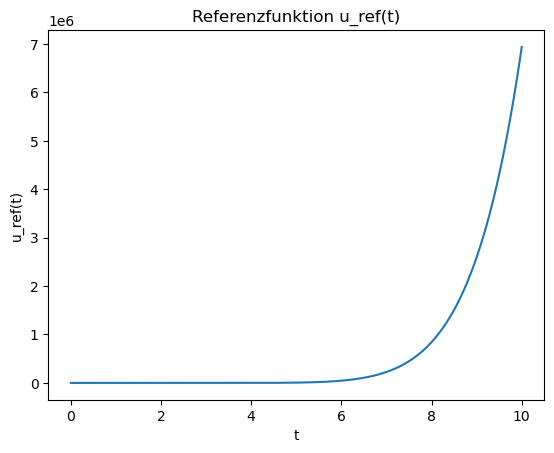

In [18]:
# Zeitachse
t_vals = np.linspace(0.0, 10.0, 400)
u_vals = u_ref(t_vals)

# Plot
plt.figure()
plt.plot(t_vals, u_vals)
plt.xlabel("t")
plt.ylabel("u_ref(t)")
plt.title("Referenzfunktion u_ref(t)")
plt.show()

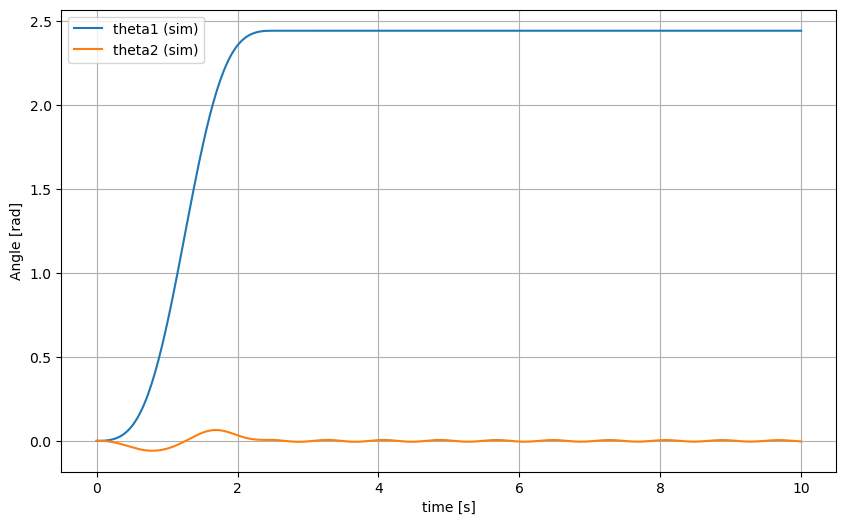

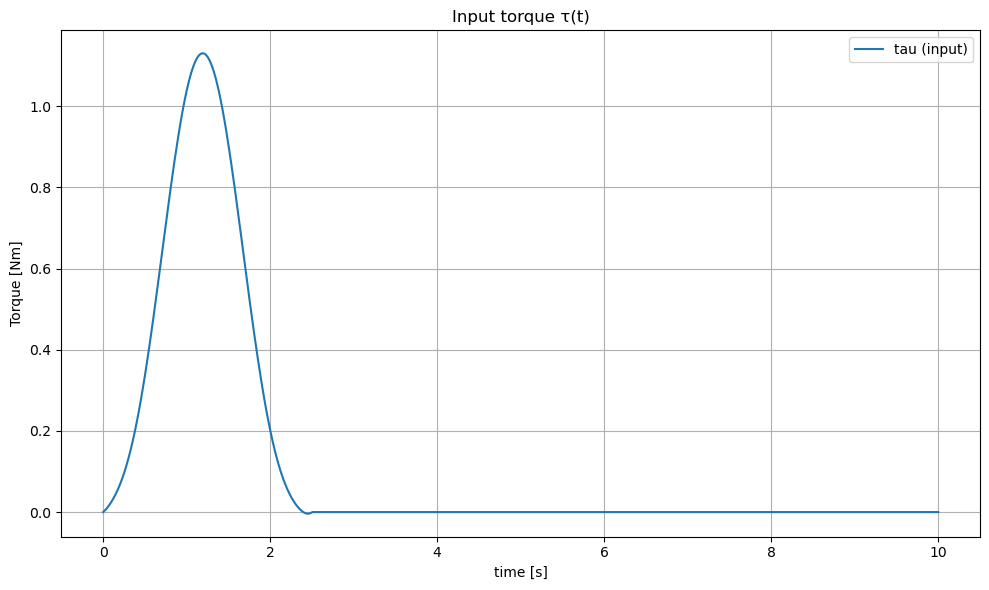

In [19]:
def input_tau(t: float) -> float:
    if t<0: return 0.0
    if t>T: return 0.0
    return u_ref(t)


non_linear_furuta_system = furu_calc.get_non_linear_furuta_system(params)
def simulation_system(t, x):
    theta1, theta1_dot, theta2, theta2_dot = x
    u = input_tau(t)
    return non_linear_furuta_system(t, x, u)

x0 = [0.0, 0.0, 0.0, 0.0]

# Tipp: direkt auf CSV-Zeitpunkten integrieren, damit Vergleich 1:1 ist
sol = solve_ivp(
    simulation_system,
    (float(t_vals[0]), float(t_vals[-1])),
    x0,
    t_eval=t_vals,
    rtol=1e-6,
    atol=1e-9,
    max_step=1e-3,
)

theta1_sim = sol.y[0]
theta2_sim = sol.y[2]
tau_sim = np.array([input_tau(t) for t in t_vals])

plt.figure(figsize=(10, 6))
plt.plot(t_vals, theta1_sim, label="theta1 (sim)")
plt.plot(t_vals, theta2_sim, label="theta2 (sim)")
plt.ylabel("Angle [rad]")
plt.xlabel("time [s]")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_vals, tau_sim, label="tau (input)")
plt.ylabel("Torque [Nm]")
plt.xlabel("time [s]")
plt.title("Input torque τ(t)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()